<a href="https://colab.research.google.com/github/ontoligent-design/DS5559/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assumption

* Do not preserve punction and whitespace 
* Work with a single text

# Imports

In [0]:
import sqlite3
import pandas as pd
import re
import requests
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# F0-1: Prepare the source

In [0]:
doc_url = 'https://www.gutenberg.org/files/2701/old/moby10b.txt'
moby_text = requests.get(doc_url).text.split('\r\n')
moby_lines_raw = pd.DataFrame(moby_text, columns=['line'])
moby_lines_raw.index.name = 'line_id'

In [3]:
len(moby_lines_raw.index)

23245

In [0]:
moby_start = 318
moby_end = 23238
moby_lines = moby_lines_raw.loc[moby_start:moby_end].copy()
moby_lines.reset_index(drop=True, inplace=True)
moby_lines.index.name = 'line_id'

In [5]:
moby_lines.head(10)

,line
line_id,
0,ETYMOLOGY.
1,
2,(Supplied by a Late Consumptive Usher to a Gra...
3,
4,"The pale Usher--threadbare in coat, heart, bod..."
5,now. He was ever dusting his old lexicons and...
6,"handkerchief, mockingly embellished with all t..."
7,known nations of the world. He loved to dust ...
8,somehow mildly reminded him of his mortality.


# F2: Identify Chapters and Paragraphs

## Chapters

We apply the **milestone method** to identify, label, and group lines.

In [0]:
moby_lines['chap_ms'] = moby_lines.line\
  .str.match(r'^(?:ETYMOLOGY|CHAPTER \d+|Epilog)')

In [7]:
moby_lines.head()

,line,chap_ms
line_id,,
0,ETYMOLOGY.,True
1,,False
2,(Supplied by a Late Consumptive Usher to a Gra...,False
3,,False
4,"The pale Usher--threadbare in coat, heart, bod...",False


In [0]:
moby_lines['chap_idx'] = None # WHY
moby_lines['chap_idx'] = moby_lines[moby_lines.chap_ms]\
  .apply(lambda x: x.index)
moby_lines.chap_idx = moby_lines.chap_idx.ffill()
moby_lines.chap_idx = moby_lines['chap_idx'].astype('int')

In [9]:
moby_lines.head()

,line,chap_ms,chap_idx
line_id,,,
0,ETYMOLOGY.,True,0
1,,False,0
2,(Supplied by a Late Consumptive Usher to a Gra...,False,0
3,,False,0
4,"The pale Usher--threadbare in coat, heart, bod...",False,0


In [0]:
moby_chaps = moby_lines.groupby('chap_idx').line\
  .apply(lambda x: '\n'.join(x[:])).to_frame().reset_index(drop=True)
moby_chaps.index.name = 'chap_id'

In [11]:
moby_chaps.head()

,line
chap_id,
0,ETYMOLOGY.\n\n(Supplied by a Late Consumptive ...
1,CHAPTER 1\n\nLoomings.\n\n\nCall me Ishmael. ...
2,CHAPTER 2\n\nThe Carpet-Bag.\n\n\nI stuffed a ...
3,CHAPTER 3\n\nThe Spouter-Inn.\n\n\nEntering th...
4,CHAPTER 4\n\nThe Counterpane.\n\n\nUpon waking...


In [0]:
# Optionally removed chapter names here (split and pop off first chunk)

## Paragraphs

In [0]:
moby_paras = moby_chaps.line.str.split(r'\n\n+', expand=True).stack()\
  .to_frame().reset_index().rename(columns={'level_1':'para_id', 0:'para'})
moby_paras.set_index(['chap_id','para_id'], inplace=True)
moby_paras.para = moby_paras.para.str.replace(r'\n', ' ')

In [13]:
moby_paras.head()

para
chap_id para_id                                                   
0       0                                               ETYMOLOGY.
        1        (Supplied by a Late Consumptive Usher to a Gra...
        2        The pale Usher--threadbare in coat, heart, bod...
        3        "While you take in hand to school others, and ...
        4        "WHALE. ... Sw. and Dan. HVAL.  This animal is...

In [14]:
moby_paras.loc[(2,3)].para

'As most young candidates for the pains and penalties of whaling stop at this same New Bedford, thence to embark on their voyage, it may as well be related that I, for one, had no idea of so doing.  For my mind was made up to sail in no other than a Nantucket craft, because there was a fine, boisterous something about everything connected with that famous old island, which amazingly pleased me.  Besides though New Bedford has of late been gradually monopolising the business of whaling, and though in this matter poor old Nantucket is now much behind her, yet Nantucket was her great original--the Tyre of this Carthage;--the place where the first dead American whale was stranded.  Where else but from Nantucket did those aboriginal whalemen, the Red-Men, first sally out in canoes to give chase to the Leviathan?  And where but from Nantucket, too, did that first adventurous little sloop put forth, partly laden with imported cobblestones--so goes the story--to throw at the whales, in order t

# F3: Identify Sentences and Tokens

We identify tokens by delimitter parsing. Delimitters are represented by character classes.

## Sentences

Sentence are actually a container.

In [0]:
moby_sent = moby_paras.para.str.split(r'(?:[":;.?!\(\)]|--)', expand=True)\
  .stack()\
  .to_frame().reset_index().rename(columns={'level_2':'sent_id', 0:'sent'})
moby_sent.set_index(['chap_id', 'para_id', 'sent_id'], inplace=True)
moby_sent = moby_sent[~moby_sent.sent.str.match(r'^\s*$')]

In [0]:
# Re-order the sentence IDs -- NEED TO GENERALIZE THIS PATTERN
moby_sent['new_sent_idx'] = moby_sent.groupby(['chap_id','para_id']).cumcount()
moby_sent = moby_sent.reset_index()
moby_sent.rename(columns={'sent_id':'delete_me'}, inplace=True)
moby_sent.rename(columns={'new_sent_idx':'sent_id'}, inplace=True)
moby_sent = moby_sent.set_index(['chap_id','para_id','sent_id'])['sent']\
  .to_frame()

In [17]:
moby_sent.head()

sent
chap_id para_id sent_id                                                   
0       0       0                                                ETYMOLOGY
        1       0        Supplied by a Late Consumptive Usher to a Gram...
        2       0                                           The pale Usher
                1               threadbare in coat, heart, body, and brain
                2                                            I see him now

## Tokens

In [0]:
moby_tokens = moby_sent.sent.str.split(r'\W+', expand=True).stack()\
  .to_frame().reset_index().rename(columns={'level_3':'token_id', 0:'token'})
moby_tokens.set_index(['chap_id', 'para_id', 'sent_id', 'token_id'], inplace=True)

In [19]:
moby_tokens.head()

token
chap_id para_id sent_id token_id           
0       0       0       0         ETYMOLOGY
        1       0       0          Supplied
                        1                by
                        2                 a
                        3              Late

In [0]:
moby_tokens['norm'] = moby_tokens.token.str.lower()

In [21]:
moby_tokens.head()

token       norm
chap_id para_id sent_id token_id                      
0       0       0       0         ETYMOLOGY  etymology
        1       0       0          Supplied   supplied
                        1                by         by
                        2                 a          a
                        3              Late       late

# Create Vocabulary

In [0]:
moby_vocab = pd.DataFrame(moby_tokens.token.str.lower().sort_values().unique(), columns=['term'])
moby_vocab.index.name = 'term_id'

In [131]:
moby_vocab.sample(10)

,term
term_id,
13286,shetland
15626,turn
1179,backward
7351,hugely
8429,knaves
6706,grow
7578,imperturbable
5857,flingers
5400,extant


## Get Term ID function

In [0]:
def term_id(term):
  try:
    return moby_vocab.query("term == @term").index[0]
  except IndexError as e:
    return None

## Stopwords

In [0]:
stopwords = requests.get('https://algs4.cs.princeton.edu/35applications/stopwords.txt').text.split('\n')
stopwords[:5]
moby_vocab['sw'] = moby_vocab.term.apply(lambda x: x in stopwords or len(x) < 2 or x.isdigit())

In [26]:
moby_vocab.sample(10)

,term,sw
term_id,,
10640,parsee,False
14427,stuck,False
13227,shameful,False
7736,indigenous,False
14309,stores,False
10398,outblown,False
7530,immemorial,False
332,actual,False
10837,perdition,False


## Replace terms with IDs

In [0]:
moby_tokens['term_id'] = moby_tokens.norm.map(moby_vocab.reset_index()\
  .set_index('term').term_id)\
  .fillna(-1).astype('int')

In [28]:
moby_tokens.head()

token       norm  term_id
chap_id para_id sent_id token_id                               
0       0       0       0         ETYMOLOGY  etymology     5198
        1       0       0          Supplied   supplied    14638
                        1                by         by     2178
                        2                 a          a      190
                        3              Late       late     8580

In [0]:
moby_tokens = moby_tokens[['token','term_id']]

In [30]:
moby_tokens.head()

token  term_id
chap_id para_id sent_id token_id                    
0       0       0       0         ETYMOLOGY     5198
        1       0       0          Supplied    14638
                        1                by     2178
                        2                 a      190
                        3              Late     8580

## Remove stopwords

In [0]:
moby_tokens['sw'] = moby_tokens.term_id.map(moby_vocab.sw)
moby_tokens_ns = moby_tokens.loc[~moby_tokens.sw, ['term_id']]

In [32]:
moby_tokens_ns.head()

term_id
chap_id para_id sent_id token_id         
0       0       0       0            5198
        1       0       0           14638
                        3            8580
                        4            3292
                        5           16179

## Dispersion Plots of 'ahab' and 'whale'

### Add raw term counts to vocab

In [0]:
moby_vocab['n'] = moby_tokens.groupby('term_id').term_id.count()

In [137]:
moby_vocab.sample(10)

,term,n
term_id,,
15344,tormenting,2
15503,tremulous,3
2798,clews,1
15910,unhorse,1
14637,supplication,1
976,asphaltic,1
16069,unstaggering,1
4409,displayed,3
8620,layn,1


### Convert tokens into OHE matrix

In [0]:
kahuna = pd.get_dummies(moby_tokens_ns.reset_index()['term_id']).T

### Default method

In [0]:
def get_term_dplot(term, figsize=(15,.5)):
  print(term)
  kahuna.loc[term_id(term)].plot(figsize=figsize)
  plt.show()

ahab


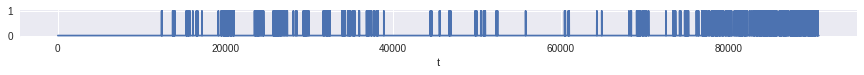

whale


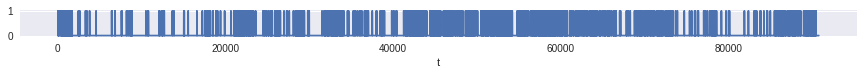

starbuck


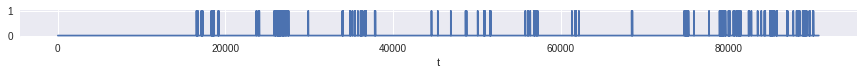

queequeg


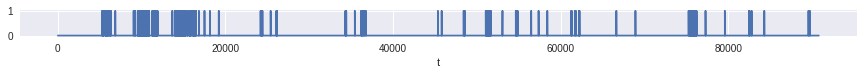

ishmael


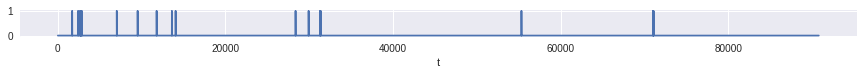

white


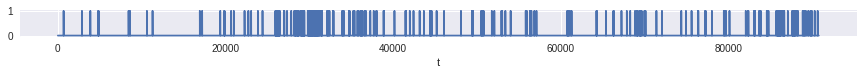

sea


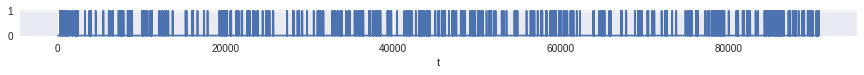

ship


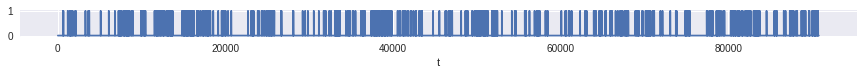

church


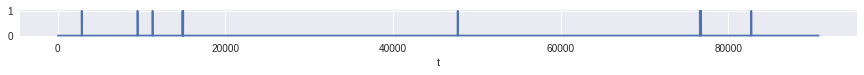

death


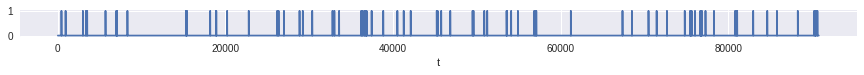

In [182]:
terms = ['ahab','whale', 'starbuck', 'queequeg', 'ishmael', 'white', 'sea', 'ship', 'church', 'death']
for term in terms:
  get_term_dplot(term)

### Seaborn method

In [0]:
df1 = pd.DataFrame({term:kahuna.loc[term_id(term)] for term in terms})
df1.index.name = 't'

In [195]:
df1.head()

,ahab,church,death,ishmael,queequeg,sea,ship,starbuck,whale,white
t,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [0]:
df2 = df1.stack().to_frame().reset_index().rename(columns={'level_1':'term', 0:'n'})

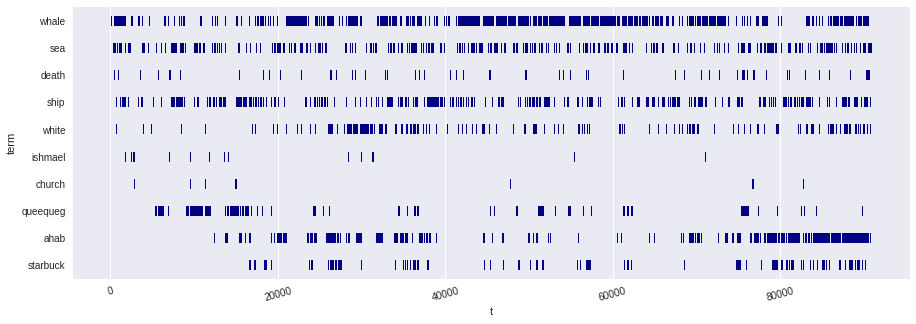

In [193]:
# set size of figure
plt.figure(figsize=(15,5))

# use horizontal stripplot with x marker size of 5
sns.stripplot(y='term', x='t', data=df2[df2.n == 1],
 orient='h', marker="$|$", color='navy', size=10)

# rotate x tick labels
plt.xticks(rotation=15)

# remove borders of plot
#plt.tight_layout()
plt.show()

# Create BOWs and TDMs

## BOW by Para

In [0]:
moby_bow = moby_tokens_ns\
  .groupby(['chap_id','para_id','term_id'])\
  .term_id.count()\
  .to_frame().rename(columns={'term_id':'n'})

In [41]:
moby_bow.head()

n
chap_id para_id term_id   
0       0       5198     1
        1       3292     1
                6584     1
                8580     1
                12913    1

## BOW by Chap

In [0]:
moby_bow_chaps = moby_tokens_ns\
  .groupby(['chap_id','term_id'])\
  .term_id.count()\
  .to_frame().rename(columns={'term_id':'n'})

In [43]:
moby_bow_chaps.head()

n
chap_id term_id   
0       223      1
        259      1
        260      1
        289      2
        319      1

## BOW by Chunk

In [0]:
moby_tokens_ns['ord'] = moby_tokens_ns.reset_index().index + 1

In [0]:
# Divide text evenly in K chunks
K = 100
N = moby_tokens_ns.ord.max()
C = int(round(N / K))
T = C * K

In [46]:
N, K, C, T

(90814, 100, 908, 90800)

In [0]:
moby_tokens_ns['chunk'] = moby_tokens_ns.ord.div(C).round().astype('int')

In [48]:
moby_tokens_ns.head()

term_id  ord  chunk
chap_id para_id sent_id token_id                     
0       0       0       0            5198    1      0
        1       0       0           14638    2      0
                        3            8580    3      0
                        4            3292    4      0
                        5           16179    5      0

In [0]:
# moby_tokens_ns.chunk.value_counts()

In [0]:
moby_bow_chunks = moby_tokens_ns\
  .groupby(['chunk','term_id'])\
  .term_id.count()\
  .to_frame().rename(columns={'term_id':'n'})

In [0]:
# moby_bow_chunks.unstack().fillna(0).sum(1)

## DTM by Para

In [0]:
moby_dtm = moby_bow.unstack().fillna(0)
moby_dtm.columns = moby_dtm.columns.droplevel()

In [53]:
moby_dtm.head()

term_id          48     55     85     89     91     98     101    105    \
chap_id para_id                                                           
0       0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        1          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        2          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        3          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        4          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

term_id          114    128    ...    17129  17130  17131  17132  17133  \
chap_id para_id                ...                                        
0       0          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        1          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        2          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        3          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        4          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   

term_id          17134  17135  17136  17137  17138  
chap_id para_id                                     
0       0          0.0    0.0    0.0    0.0    0.0  
        1          0.0    0.0    0.0    0.0    0.0  
        2          0.0    0.0    0.0    0.0    0.0  
        3          0.0    0.0    0.0    0.0    0.0  
        4          0.0    0.0    0.0    0.0    0.0  

[5 rows x 16502 columns]

## DTM by Chap

In [0]:
moby_dtm_chaps = moby_bow_chaps.unstack().fillna(0)
moby_dtm_chaps.columns = moby_dtm_chaps.columns.droplevel()

In [55]:
moby_dtm_chaps.head()

term_id,48,55,85,89,91,98,101,105,114,128,...,17129,17130,17131,17132,17133,17134,17135,17136,17137,17138
chap_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## DTM by Chunk

In [0]:
moby_dtm_chunks = moby_bow_chunks.unstack().fillna(0)
moby_dtm_chunks.columns = moby_dtm_chunks.columns.droplevel()

In [57]:
moby_dtm_chunks.head()

term_id,48,55,85,89,91,98,101,105,114,128,...,17129,17130,17131,17132,17133,17134,17135,17136,17137,17138
chunk,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Some graphs

In [0]:
WHALE = term_id('whale')
AHAB = term_id('ahab')

In [0]:
WIDE = (15, 5)
THIN = (5, 10)

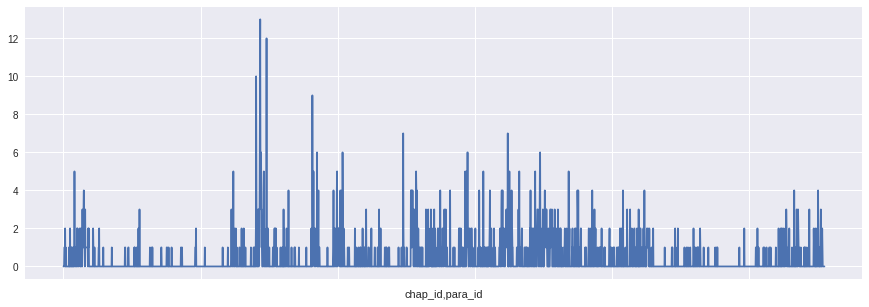

In [60]:
moby_dtm[WHALE].plot(figsize=WIDE)

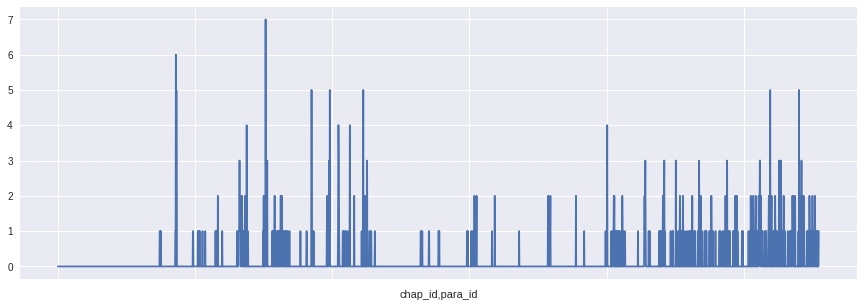

In [61]:
moby_dtm[AHAB].plot(figsize=WIDE)

# Create TFIDF Matrix

## Get N docs

In [0]:
N = len(moby_dtm.index)

In [63]:
N

2774

## TFIDF  by Para

In [0]:
moby_dtm_tfidf = moby_dtm.apply(lambda row: row / row.sum(), 1).apply(lambda col: col * np.log(N/col[col > 0].count()))

In [65]:
moby_dtm_tfidf.head()

term_id          48     55     85     89     91     98     101    105    \
chap_id para_id                                                           
0       0          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        1          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        2          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        3          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        4          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

term_id          114    128    ...    17129  17130  17131  17132  17133  \
chap_id para_id                ...                                        
0       0          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        1          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        2          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        3          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   
        4          0.0    0.0  ...      0.0    0.0    0.0    0.0    0.0   

term_id          17134  17135  17136  17137  17138  
chap_id para_id                                     
0       0          0.0    0.0    0.0    0.0    0.0  
        1          0.0    0.0    0.0    0.0    0.0  
        2          0.0    0.0    0.0    0.0    0.0  
        3          0.0    0.0    0.0    0.0    0.0  
        4          0.0    0.0    0.0    0.0    0.0  

[5 rows x 16502 columns]

## TFIDF by Chap

In [0]:
moby_dtm_tfidf_chaps = moby_dtm_chaps.apply(lambda row: row / row.sum(), 1).apply(lambda col: col * np.log(N/col[col > 0].count()))

In [0]:
# moby_dtm_tfidf_chaps.shape()

In [68]:
moby_dtm_tfidf_chaps.head()

term_id,48,55,85,89,91,98,101,105,114,128,...,17129,17130,17131,17132,17133,17134,17135,17136,17137,17138
chap_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.013693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.012705,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TFIDF by Chunk

In [0]:
moby_dtm_tfidf_chunks = moby_dtm_chunks.apply(lambda row: row / row.sum(), 1).apply(lambda col: col * np.log(N/col[col > 0].count()))

In [70]:
moby_dtm_tfidf_chunks.head()

term_id,48,55,85,89,91,98,101,105,114,128,...,17129,17130,17131,17132,17133,17134,17135,17136,17137,17138
chunk,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.008741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Term Frequency Graphs

## TFIDF by Para

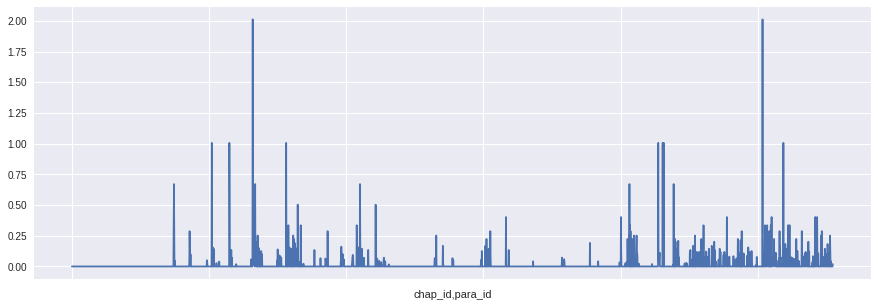

In [71]:
moby_dtm_tfidf.T.loc[AHAB].plot(figsize=WIDE)

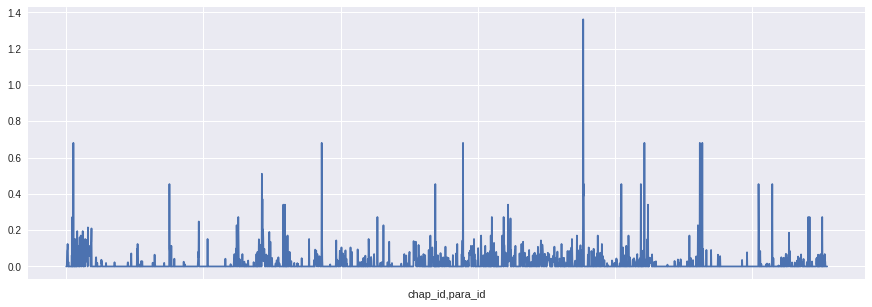

In [72]:
moby_dtm_tfidf.T.loc[WHALE].plot(figsize=WIDE)

## TFIDF by Chap

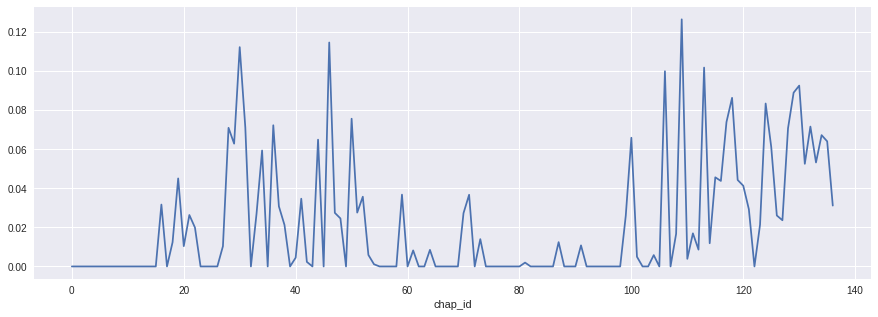

In [73]:
moby_dtm_tfidf_chaps.T.loc[AHAB].plot(figsize=WIDE)

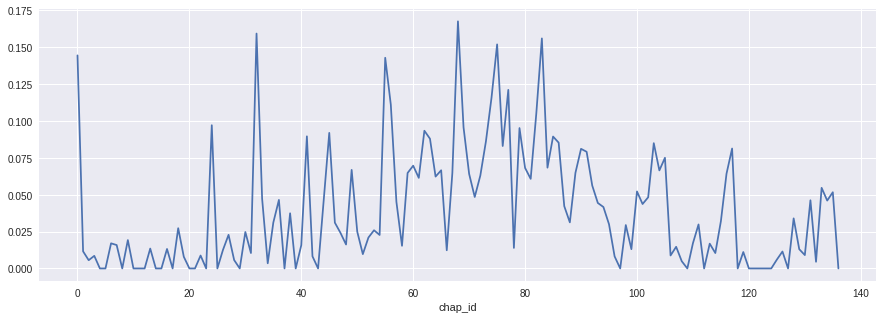

In [74]:
moby_dtm_tfidf_chaps.T.loc[WHALE].plot(figsize=WIDE)

## TFIDF by Chunk

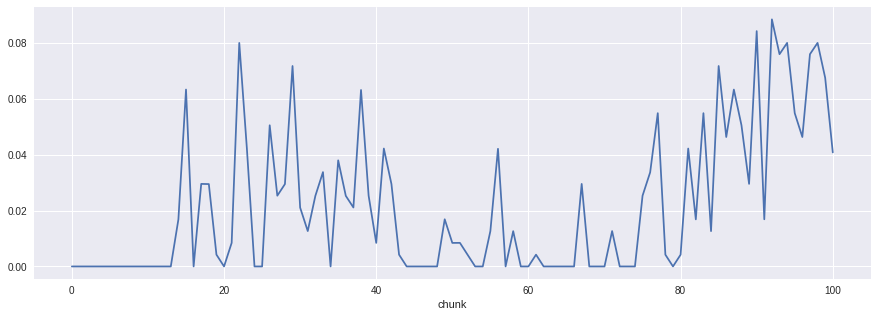

In [76]:
moby_dtm_tfidf_chunks.T.loc[AHAB].plot(figsize=WIDE)

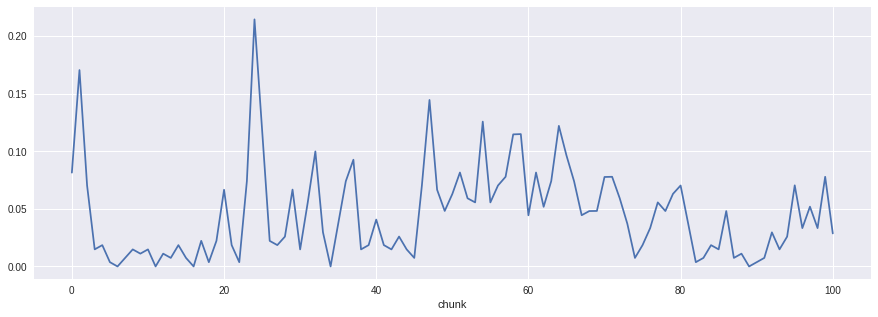

In [77]:
moby_dtm_tfidf_chunks.T.loc[WHALE].plot(figsize=WIDE)

# Stats

In [0]:
import scipy.stats as sps

In [0]:
words_ahab = moby_dtm_tfidf_chunks.T.loc[AHAB]
words_whale = moby_dtm_tfidf_chunks.T.loc[WHALE]

In [0]:
sps.ttest_rel(words_ahab, words_whale)

In [0]:
sps.ttest_ind(words_ahab, words_whale)